In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, Activation
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model

In [2]:
import yfinance as yf
from datetime import datetime
import pandas as pd
from numpy import concatenate
import numpy as np

In [3]:
#Ensuring the use of gpu tensorflow

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [4]:
#Enter info regarding model

num_inputs=4
look_back = 60
forward_days = 1
num_periods = 20

In [5]:
today = datetime.today().strftime('%Y-%m-%d')
idx = pd.date_range('2017-01-01', today)

df_A = yf.download("BTC-USD", start="2017-01-01", end=today)
df_A = df_A["Close"]
df_A = df_A.reindex(idx, fill_value=0, method="nearest")

df_B = yf.download("%5EGSPC", start="2017-01-01", end=today)
df_B = df_B["Close"]
df_B = df_B.reindex(idx, fill_value=0, method="nearest")

df_C = yf.download("DX-Y.NYB", start="2017-01-01", end=today)
df_C = df_C["Close"]
df_C = df_C.reindex(idx, fill_value=0, method="nearest")

df_D = yf.download("GC=F", start="2017-01-01", end=today)
df_D = df_D["Close"]
df_D = df_D.reindex(idx, fill_value=0, method="nearest")

timeseries=  pd.concat([df_A, df_B, df_C, df_D], axis=1)

timeseries.columns=(["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"])

scl = MinMaxScaler()

timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]] = scl.fit_transform(timeseries[["Close-btc", "Close-sp500", "Close-dxy", "Close-gold"]])

timeseries["Close-btc-output"] = timeseries["Close-btc"]
timeseries["Close-btc-output"] = timeseries["Close-btc-output"].shift(-1)
timeseries.drop(timeseries.tail(1).index, inplace=True)



array = timeseries.values

#split in Train and Test
division = len(array) - num_periods*forward_days

array_test = array[division:]
array_train = array[:division]
# split into input and outputs
X_train, Y_train = array_train[:, :-1], array_train[:, -1]
X_test, Y_test = array_test[:, :-1], array_test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

In [7]:
print(X_train.shape, Y_train.shape, X_validate.shape, Y_validate.shape, X_test.shape, Y_test.shape)

(966, 1, 4)(966,)(242, 1, 4)(242,)(20, 1, 4)(20,)


## Training the LSTM (Treinando a LSTM)

In [8]:
class MyHyperModel(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        
        # Specify model
        model = Sequential()
        NUM_NEURONS_FirstLayer = hp.Choice('NUM_NEURONS_FirstLayer',values=[80, 90, 100, 120])

        model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))

        model.add(Dropout(hp.Float('dropout_1', 0, 0.4, step=0.1, default=0)))

        
        NUM_NEURONS_SecondLayer = hp.Choice('NUM_NEURONS_SecondLayer',values=[30, 40, 50, 60, 70])
        model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))

        model.add(Dropout(hp.Float('dropout_2', 0, 0.4, step=0.1, default=0)))

        # Output layer
        model.add(Dense(forward_days, activation='linear'))

        # Compile the constructed model and return it
        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[0.01, 0.001, 0.0001])),
            loss='mean_squared_error')

        return model
    


hypermodel = MyHyperModel(num_classes=1)    

In [9]:
%%capture

# Construct the RandomSearch tuner using the hypermodel class created
random_tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial = 1,
    seed=10, 
    project_name='lstm-kerastuner-multi',
    directory="C:\\Users\\feder\\Desktop\\Progetto bitcoin\\multivariato")


# Search for the best parameters of the neural network using the contructed Hypberband tuner
random_tuner.search(X_train, Y_train,
             epochs=100,
             validation_data=(X_validate, Y_validate))


INFO:tensorflow:Oracle triggered exit


In [10]:
random_params = random_tuner.get_best_hyperparameters()[0]

#best_model = random_tuner.hypermodel.build(random_params)
best_model = random_tuner.get_best_models(num_models=1)[0]


In [11]:
print("Evalutation of best performing model:")
print(best_model.evaluate(X_validate, Y_validate))


Evalutation of best performing model:
1/8 [==>...........................] - ETA: 0s - loss: 4.6064e-08/8 [==============================] - 0s 3ms/step - loss: 3.3975e-04
0.00033974627149291337


In [12]:
random_tuner.results_summary()

In [13]:
#Saving the model
file_name = 'LSTM_BTC_tuned_multi.h5'
best_model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `LSTM_BTC_tuned_multi.h5` to disk


***

In [166]:
best_model = load_model("LSTM_BTC_tuned_multi.h5")

In [18]:
# Train the best fitting model
#history = best_model.fit(X_train,Y_train,epochs=100,validation_data=(X_validate,Y_validate),shuffle=False, verbose=2)
# Check the accuracy plots
#random_accuracy_df = pd.DataFrame(best_model.history.history)

In [21]:
#plt.figure(figsize = (15,10))

#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
#plt.legend(loc='best')
#plt.show()

In [14]:
yhat = best_model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

inv_yhat = concatenate((yhat, X_test[:,1:]), axis=1)
inv_yhat = scl.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

Y_test = Y_test.reshape((len(Y_test)), 1)
inv_y = concatenate((Y_test, X_test[:, 1:]), axis=1)
inv_y = scl.inverse_transform(inv_y)
inv_y = inv_y[:,0]

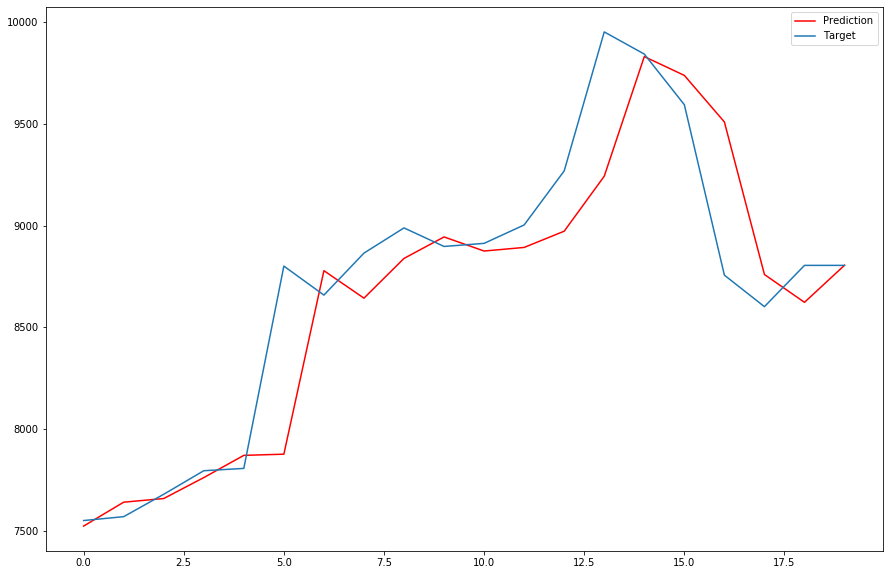

In [15]:
plt.figure(figsize = (15,10))

    
plt.plot(inv_yhat, color='r', label='Prediction') 
    
plt.plot(inv_y, label='Target')
plt.xticks(np.arange(0, 20, 1), np.arange(1, 21, 1))
plt.xlabel('Days')
plt.ylabel('USD')
plt.legend(loc='best')
plt.show()